In [26]:
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()

host = os.getenv("SUPABASE_HOST")
db = os.getenv("SUPABASE_DB")
user = os.getenv("SUPABASE_USER")
password = os.getenv("SUPABASE_PASSWORD")
port = os.getenv("SUPABASE_PORT")

connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"
engine = create_engine(connection_string)

test_query = "SELECT COUNT(*) FROM public.customer_analysis_view;"
result = pd.read_sql(test_query, engine)
print(result)

   count
0   2239


In [27]:
# Pull the full unified view
df = pd.read_sql("SELECT * FROM public.customer_analysis_view", engine)

# Basic sanity checks
df.info()
df.describe().T
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   customerid           2239 non-null   int64 
 1   Year_Birth           2239 non-null   int64 
 2   Education            2239 non-null   object
 3   Marital_Status       2239 non-null   object
 4   Income               2239 non-null   int64 
 5   Kidhome              2239 non-null   object
 6   Teenhome             2239 non-null   object
 7   Dt_Customer          2239 non-null   object
 8   Recency              2239 non-null   int64 
 9   MntWines             2239 non-null   int64 
 10  MntFruits            2239 non-null   int64 
 11  MntMeatProducts      2239 non-null   int64 
 12  MntFishProducts      2239 non-null   int64 
 13  MntSweetProducts     2239 non-null   int64 
 14  MntGoldProds         2239 non-null   int64 
 15  NumDealsPurchases    2239 non-null   int64 
 16  NumWeb

customerid             0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp1           0
AcceptedCmp2           0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
Response               0
Complain               0
Z_CostContact          0
Z_Revenue              0
dtype: int64

In [28]:
from datetime import date

# Age based on birth year
df["Age"] = date.today().year - df["Year_Birth"]

# Total money spent across all product categories
spend_cols = ["MntWines","MntFruits","MntMeatProducts",
              "MntFishProducts","MntSweetProducts","MntGoldProds"]
df["Total_Spend"] = df[spend_cols].sum(axis=1)

# Total number of purchases across all channels
purchase_cols = ["NumDealsPurchases","NumWebPurchases",
                 "NumCatalogPurchases","NumStorePurchases"]
df["Total_Purchases"] = df[purchase_cols].sum(axis=1)

# Quick composite score to estimate overall customer value
# Composite score (50% spend, 30% recency, 20% purchases)
# Higher = more valuable, recent, and active customer
df["Customer_Value_Score"] = (
    0.5 * df["Total_Spend"] / df["Total_Spend"].max() +
    0.3 * (1 - df["Recency"] / df["Recency"].max()) +
    0.2 * df["Total_Purchases"] / df["Total_Purchases"].max()
)

df["Customer_Value_Score"] = df["Customer_Value_Score"].round(3)

# Remove unrealistic ages
df = df[df["Age"] <= 100]

# Fix Education categories
df['Education'] = df['Education'].replace({
    "Basic": "Basic Education",
    "2n Cycle": "Secondary Education",
    "Graduation": "Bachelor Degree",
    "Master": "Master Degree",
    "PhD": "PhD"
})

# Check new columns look right
df[["Age","Total_Spend","Total_Purchases","Customer_Value_Score"]].describe()

,Age,Total_Spend,Total_Purchases,Customer_Value_Score
count,2236.000000,2236.000000,2236.000000,2236.000000
mean,56.101968,605.986583,14.872540,0.338761
std,11.703281,601.865156,7.677874,0.170070
min,29.000000,5.000000,0.000000,0.029000
25%,48.000000,69.000000,8.000000,0.206000
50%,55.000000,396.500000,15.000000,0.319000
75%,66.000000,1045.500000,21.000000,0.462000
max,85.000000,2525.000000,44.000000,0.830000


In [29]:
# Linear Regression - Predicting Total Spend
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Select features and target
features = ["Age", "Income", "Total_Purchases", "Recency"]
target = "Total_Spend"

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("R^2:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

R^2: 0.749
MAE: 232.63


In [30]:
# K-Means Clustering - Segment customers by behavior
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables to base clusters on
cluster_features = ["Total_Spend", "Total_Purchases", "Recency"]

# Scale data for fair clustering (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

# Fit KMeans (4 clusters for now - tweak later if needed)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Review segment averages
df.groupby("Cluster")[cluster_features + ["Income", "Customer_Value_Score"]].mean().round(1)

,Total_Spend,Total_Purchases,Recency,Income,Customer_Value_Score
Cluster,,,,,
0,128.3,8.6,24.6,36831.2,0.3
1,1151.0,21.5,73.3,68438.0,0.4
2,1123.9,21.9,23.4,68696.4,0.6
3,138.7,9.0,74.8,37572.4,0.1


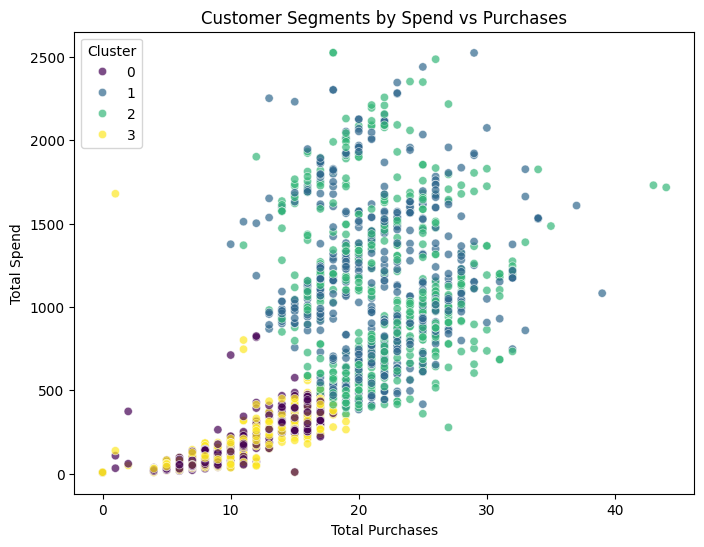

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="Total_Purchases",
    y="Total_Spend",
    hue="Cluster",
    palette="viridis",
    alpha=0.7
)
plt.title("Customer Segments by Spend vs Purchases")
plt.xlabel("Total Purchases")
plt.ylabel("Total Spend")
plt.legend(title="Cluster", loc="upper left")
plt.show()

In [32]:
import os

os.makedirs("data/cleaned", exist_ok=True)

df.to_csv("../data/cleaned/customer_profitability_final.csv", index=False)
print("Saved")

Saved


In [33]:
import os
print(os.getcwd())


C:\Projects-2025-2026\Customer_Profitability_Analysis\python
